#     Data Analaysis and Machine learning model to predict trades 

Loading Libraries to use required functionalities.

In [34]:
%matplotlib inline
import re
import matplotlib
import numpy as np
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from bs4 import BeautifulSoup

Downloading stopwords list present in NLTK .

In [59]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shivr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Null value records are shown below ,attributes like what ,services and strategy 
have more than 90% values as Null .

In [60]:
train_data = pd.read_csv('training_dataset.csv')
print('Train data dimensions:',wine_data.shape)
test_data = pd.read_csv('test_dataset.csv')
print('Test data dimensions',test_data.shape)
null_columns = train_data.columns[train_data.isnull().any()]
print('Null values percentage in each column train:')H
print(train_data[null_columns].isnull().sum()/len(train_data))
null_columns = test_data.columns[test_data.isnull().any()]
print('Null values percentage in each column test:')
print(test_data[null_columns].isnull().sum()/len(test_data))

Train data dimensions: (24838, 7)
Test data dimensions (6203, 7)
Null values percentage in each column train:
about       0.646711
what        0.982889
services    0.916056
strategy    0.996980
dtype: float64
Null values percentage in each column test:
about       0.637917
what        0.984040
services    0.908915
strategy    0.996292
dtype: float64


Combining descriptions present in home,about,what,services and strategy into single summary column.Summary will have all features important to identify correct trade associated with those features

Filling Nulls with space and Combining features home ,about,what,services and strategy to a single column named as summary.Reason to combine those features  is to create holistic feature vectors.

In [75]:
train_data.fillna(' ',inplace=True)
test_data.fillna(' ',inplace=True)
train_data['summary']=train_data['home'].astype(str) + train_data['about'] + train_data['what'] + train_data['services'] + train_data['strategy']
train_data.head()
test_data['summary']=test_data['home'].astype(str) + test_data['about'] + test_data['what'] + test_data['services'] + test_data['strategy']
test_data.head()
print('Row percentage for each trade in train:')
print(np.round(train_data.trade.value_counts()/len(train_data)*100,1))
print('Row percentage for each trade in test:')
print(np.round(test_data.trade.value_counts()/len(test_data)*100,1))


Row percentage for each trade in train:
Tradesmen                                     23.7
Health, Beauty And Complementary Therapies    20.4
Investment And Financial Services             18.7
Real Estate Agent                             14.7
It & Technology                                9.1
Hr And Recruitment                             3.9
Marketing                                      3.1
Insurance Brokers                              3.0
Photography                                    2.2
Beauty                                         0.7
Film And Video Production                      0.5
Name: trade, dtype: float64
Row percentage for each trade in test:
Tradesmen                                     23.7
Health, Beauty And Complementary Therapies    20.4
Investment And Financial Services             18.7
Real Estate Agent                             14.7
It & Technology                                9.1
Hr And Recruitment                             3.9
Marketing                 

                    Distribution of texts for each trade

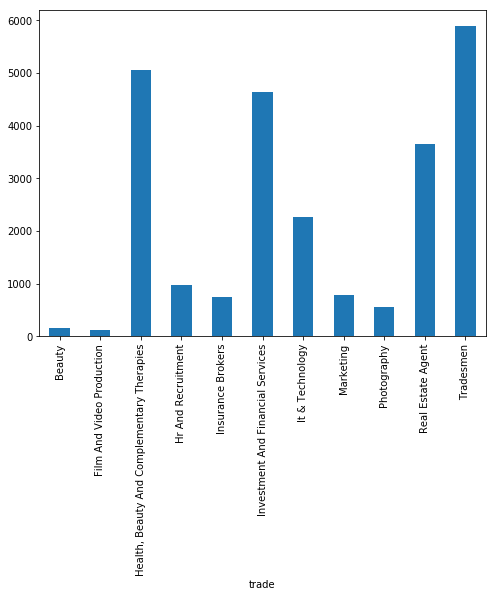

In [76]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
train_data.groupby('trade').summary.count().plot.bar(ylim=0)
plt.show()

In [77]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text
    
train_data['summary'] = train_data['summary'].apply(clean_text)
test_data['summary'] = test_data['summary'].apply(clean_text)

C:\Users\shivr\Anaconda3\lib\site-packages\bs4\__init__.py:282: UserWarning: "https://twitter.com/nationradio/status/984713875919724544…thethethethe" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Cleaning train and test text values present in summary column.

In [78]:
train_data['summary'][2]

'know 4 5 people prefer websites couk extension searching online whether youre professional starting online company business uk get perfect couk domain today help audience find site easier world wide web looking affordable easy solution build site scratch website builder may solution youve searching come free domain name also access fantastic collection predesigned templates customise liking best thing build website clicks even dont technical knowledge may cheapest solution creating websites weve added features need build good looking website get online time try todaythethethethe'

Creation of modelling pipelines

In [79]:
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

# train the model using X_dtm & y
train_data.fit(train_data['summary'], train_data['trade'])
prediction = NB_pipeline.predict(wine_data['summary'])
print('Train accuracy is {}'.format(accuracy_score(train_data['trade'], prediction)))
# compute the testing accuracy
prediction = NB_pipeline.predict(test_data['summary'])
print('Test accuracy is {}'.format(accuracy_score(test_data['trade'], prediction)))

Train accuracy is 0.738626298413721
Test accuracy is 0.6787038529743672


In [80]:

SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
# train the model using X_dtm & y
SVC_pipeline.fit(train_data['summary'], train_data['trade'])
prediction = SVC_pipeline.predict(train_data['summary'])
print('Train accuracy is {}'.format(accuracy_score(train_data['trade'], prediction)))
# compute the testing accuracy
prediction = SVC_pipeline.predict(test_data['summary'])
print('Test accuracy is {}'.format(accuracy_score(test_data['trade'], prediction)))



Train accuracy is 0.9801916418391174
Test accuracy is 0.7963888441076898


In [81]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

# train the model using X_dtm & y
LogReg_pipeline.fit(train_data['summary'], train_data['trade'])
prediction = LogReg_pipeline.predict(wine_data['summary'])
print('Train accuracy is {}'.format(accuracy_score(train_data['trade'], prediction)))
# compute the testing accuracy
prediction = LogReg_pipeline.predict(test_data['summary'])
print('Test accuracy is {}'.format(accuracy_score(test_data['trade'], prediction)))

test_data['prediction']=prediction

Train accuracy is 0.8646428859006361
Test accuracy is 0.7986458165403837


In [82]:
pd.crosstab(test_data['trade'],test_data['prediction'])

prediction                                  Beauty  Film And Video Production  \
trade                                                                           
Beauty                                           6                          0   
Film And Video Production                        0                          2   
Health, Beauty And Complementary Therapies       0                          0   
Hr And Recruitment                               0                          0   
Insurance Brokers                                0                          0   
Investment And Financial Services                0                          0   
It & Technology                                  1                          0   
Marketing                                        0                          0   
Photography                                      0                          0   
Real Estate Agent                                0                          1   
Tradesmen                                        0                          0   

prediction                                  Health, Beauty And Complementary Therapies  \
trade                                                                                    
Beauty                                                                              10   
Film And Video Production                                                            1   
Health, Beauty And Complementary Therapies                                        1119   
Hr And Recruitment                                                                  12   
Insurance Brokers                                                                    0   
Investment And Financial Services                                                   48   
It & Technology                                                                     10   
Marketing                                                                            4   
Photography                                                                          4   
Real Estate Agent                                                                   23   
Tradesmen                                                                            7   

prediction                                  Hr And Recruitment  \
trade                                                            
Beauty                                                       0   
Film And Video Production                                    0   
Health, Beauty And Complementary Therapies                   2   
Hr And Recruitment                                         164   
Insurance Brokers                                            1   
Investment And Financial Services                           11   
It & Technology                                              0   
Marketing                                                    2   
Photography                                                  0   
Real Estate Agent                                            2   
Tradesmen                                                    0   

prediction                                  Insurance Brokers  \
trade                                                           
Beauty                                                      0   
Film And Video Production                                   0   
Health, Beauty And Complementary Therapies                  0   
Hr And Recruitment                                          1   
Insurance Brokers                                          94   
Investment And Financial Services                          18   
It & Technology                                             0   
Marketing                                                   0   
Photography                                                 0   
Real Estate Agent                                           2   
Tradesmen                                                   0   

prediction                                  Investment And Financial S

In [83]:
from sklearn.metrics import classification_report
y_true = test_data['trade']
y_pred = prediction
target_names = categories
print(classification_report(y_true, y_pred, target_names=target_names))

                                           precision    recall  f1-score   support

                                Tradesmen       0.86      0.15      0.26        40
Health,Beauty And Complementary Therapies       0.67      0.06      0.12        31
        Investment And Financial Services       0.90      0.89      0.89      1264
                        Real Estate Agent       0.90      0.68      0.78       241
                          It & Technology       0.82      0.51      0.63       185
                       Hr And Recruitment       0.63      0.76      0.69      1160
                                Marketing       0.82      0.76      0.79       565
                        Insurance Brokers       0.79      0.54      0.64       194
                              Photography       0.95      0.70      0.80       139
                                   Beauty       0.87      0.76      0.81       911
                Film And Video Production       0.80      0.92      0.85      1473

  